In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from mplsoccer import Sbopen,Pitch
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np

In [3]:
parser = Sbopen()

In [4]:
# Define competitions and seasons
competitions = [
    
    {"competition_id": 1267, "season_id": 107, "name": "African Cup of Nations"}
    
]


In [5]:
matches = parser.match(1267, 107)
EG_games=matches[matches['home_team_name'] == 'Equatorial Guinea']['match_id'].tolist() + matches[matches['away_team_name'] == 'Equatorial Guinea']['match_id'].tolist()
print(EG_games)

[3922239, 3920408, 3920397, 3920386]


In [6]:
matches[(matches["home_team_name"] == 'Equatorial Guinea') | (matches["away_team_name"]=='Equatorial Guinea')][["home_team_name","away_team_name"]]

,home_team_name,away_team_name
5,Equatorial Guinea,Guinea
17,Nigeria,Equatorial Guinea
31,Equatorial Guinea,Côte d'Ivoire
42,Equatorial Guinea,Guinea-Bissau


In [7]:
matches[["home_team_name","away_team_name"]]

,home_team_name,away_team_name
0,Nigeria,Côte d'Ivoire
1,South Africa,Congo DR
2,Côte d'Ivoire,Congo DR
3,Nigeria,South Africa
4,Senegal,Côte d'Ivoire
5,Equatorial Guinea,Guinea
6,Mali,Côte d'Ivoire
7,Cape Verde Islands,South Africa
8,Mali,Burkina Faso
9,Congo DR,Guinea


In [8]:
match_ids =[3922239, 3920408, 3920397, 3920386]
events_list = [parser.event(mid)[0] for mid in match_ids]
all_events = pd.concat(events_list, ignore_index=True)


In [9]:
nsue_shots = all_events[
    (all_events["player_name"] == "Emilio Nsue López") &
    (all_events["type_name"] == "Shot")
]
nsue_shots["outcome_name"].value_counts()

outcome_name
Goal     5
Off T    3
Post     1
Name: count, dtype: int64

In [10]:
total_shots = len(nsue_shots)

on_target = nsue_shots[
    nsue_shots["outcome_name"].isin(["Saved", "Goal", "Saved To Post"])
]

on_target_count = len(on_target)
print(total_shots, on_target_count)

9 5


In [11]:
shot_accuracy = (on_target_count / total_shots) * 100
print(f"Shot Accuracy: {shot_accuracy:.2f}%")

Shot Accuracy: 55.56%


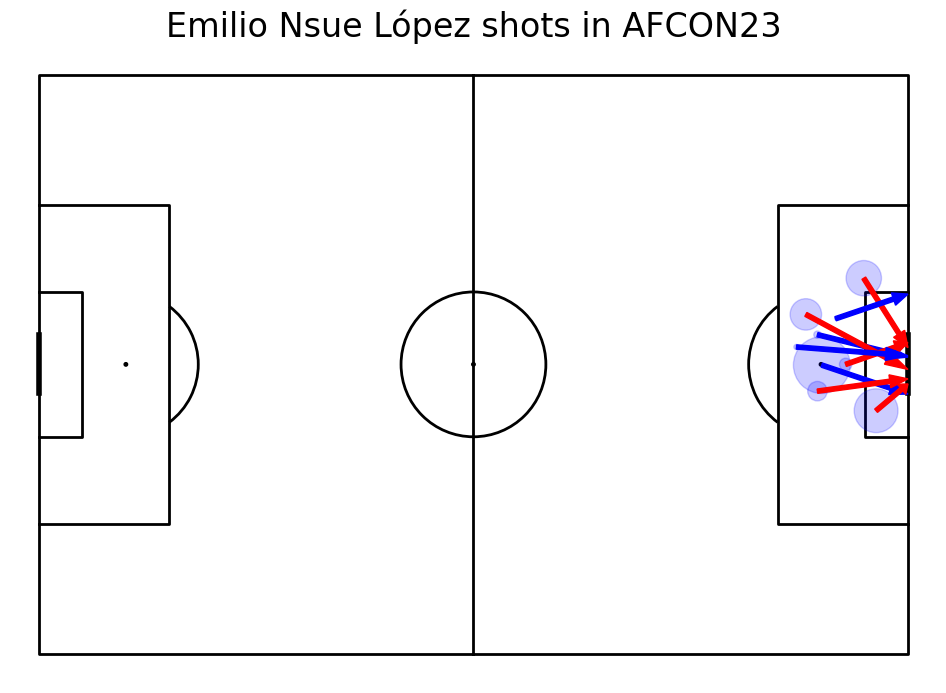

In [12]:

pitch=Pitch(line_color='black')
fig,ax=pitch.draw(figsize=(10,7))
for i,thepass in nsue_shots.iterrows():
    
        x=thepass['x']
        y=thepass['y']
        if thepass['outcome_name']=='Goal':
            color='red'
        else:
               color='blue'
        circleSize=thepass["shot_statsbomb_xg"]*5
        passCircle=plt.Circle((x,y),circleSize,color="blue")
        
        passCircle.set_alpha(0.2)
        ax.add_patch(passCircle)
        dx=thepass['end_x']-x
        dy=thepass['end_y']-y
        passArrow=plt.Arrow(x,y,dx,dy,width=3,color=color)
        ax.add_patch(passArrow)
ax.set_title("Emilio Nsue López shots in AFCON23",fontsize=24)
fig.set_size_inches(10,7)
plt.show()

In [13]:
all_events["type_name"].unique()

array(['Starting XI', 'Half Start', 'Pass', 'Ball Receipt', 'Carry',
       'Clearance', 'Pressure', 'Ball Recovery', 'Block', 'Shot',
       'Goal Keeper', 'Duel', 'Miscontrol', 'Foul Committed', 'Foul Won',
       '50/50', 'Dispossessed', 'Dribble', 'Interception',
       'Dribbled Past', 'Injury Stoppage', 'Referee Ball-Drop',
       'Half End', 'Tactical Shift', 'Substitution', 'Player Off',
       'Player On', 'Bad Behaviour', 'Shield', 'Error', 'Own Goal For',
       'Own Goal Against'], dtype=object)

In [14]:
player_name = "Emilio Nsue López"
passes_to_player = all_events[
    (all_events['type_name'] == 'Pass') &
    (all_events['pass_recipient_name'] == player_name)
]

In [15]:
passes_inside_box = passes_to_player[
    (passes_to_player['end_x'] >= 96) & (passes_to_player['end_x'] <= 120) &
    (passes_to_player['end_y'] >= 18) & (passes_to_player['end_y'] <= 62)
]

In [16]:
pass_ids = passes_inside_box['id'].tolist()


all_events_sorted = all_events.sort_values(['match_id', 'index']).reset_index(drop=True)


pass_event_rows = all_events_sorted[all_events_sorted['id'].isin(pass_ids)].index

receiver_actions = []

for row in pass_event_rows:
    pass_event = all_events_sorted.iloc[row]
    match_id = pass_event["match_id"]

    # search forward for Nsue's next event within the same match
    for next_row in range(row + 1, len(all_events_sorted)):
        next_event = all_events_sorted.iloc[next_row]

        # if match changes → stop
        if next_event["match_id"] != match_id:
            break

        # if Nsue performs the event → this is his next action
        if next_event["player_name"] == player_name:
            receiver_actions.append(next_event)
            break
# Convert to DataFrame
receiver_actions_df = pd.DataFrame(receiver_actions)
nsue_under_pressure_receipts = receiver_actions_df[
    receiver_actions_df['under_pressure'] == True
]
passes_per_match = nsue_under_pressure_receipts.groupby("match_id").size()
average_per_match = passes_per_match.mean()


print("Passes received under pressure inside box per match:")
print(passes_per_match)

print("\nAverage per match:", average_per_match)

Passes received under pressure inside box per match:
match_id
3920386    2
3920408    1
3922239    1
dtype: int64

Average per match: 1.3333333333333333


In [17]:
# 1. Filter receptions under pressure
under_pressure_receptions = passes_to_player[
    passes_to_player['under_pressure'] == True
]

# 2. Sort these receptions to preserve match timeline
under_pressure_passes = under_pressure_receptions.sort_values(
    ['match_id', 'period', 'minute', 'second', 'index']
).copy()

kept_flags = []

for idx, row in under_pressure_passes.iterrows():

    # 3. Extract all events from this match
    match_events = all_events[
        all_events['match_id'] == row['match_id']
    ].sort_values(
        ['period', 'minute', 'second', 'index']
    ).reset_index(drop=False)  # "index" now contains StatsBomb index

    # 4. Real StatsBomb index for this reception event
    sb_index = row['index']

    # 5. Locate this event
    loc = match_events.index[match_events['index'] == sb_index]

    if len(loc) == 0:
        kept_flags.append(False)
        continue

    event_idx = loc[0]

    # ------------------------------------------------------------------
    # 6. True Possession Check
    # ------------------------------------------------------------------
    kept = True  # assume kept until proven otherwise
    player_team = row['team_name']

    # Iterate forward through events
    for i in range(event_idx + 1, len(match_events)):

        next_team = match_events.iloc[i]['team_name']

        # If opponent gains possession before player team does anything else → LOST
        if next_team != player_team:
            kept = False
            break

        # If player's team performs any action → KEPT
        if next_team == player_team:
            kept = True
            break

    kept_flags.append(kept)

# 7. Add to dataframe
under_pressure_passes['kept_possession'] = kept_flags

# 8. Filter kept balls
kept_under_pressure = under_pressure_passes[under_pressure_passes['kept_possession']]

# 9. Count
num_kept = kept_under_pressure.shape[0]
total = under_pressure_passes.shape[0]

print("Passes received under pressure:", total)
print("Passes kept under pressure:", num_kept)
print(f"Percentage kept: {num_kept/total*100:.2f}%")


Passes received under pressure: 35
Passes kept under pressure: 28
Percentage kept: 80.00%


In [18]:
matches = parser.match(1267, 107)   # AFCON 2023 competition
match_ids = matches["match_id"].tolist()
events = pd.concat([parser.event(m)[0] for m in match_ids], ignore_index=True)


In [19]:
cb_positions = ["Center Forward" ]
central_defenders = events[events["position_name"].isin(cb_positions)]



In [20]:
all_shots = central_defenders[central_defenders["type_name"] == "Shot"]
all_shots["outcome_name"].value_counts()


outcome_name
Off T            77
Saved            49
Blocked          38
Goal             32
Wayward          12
Post              7
Saved to Post     1
Name: count, dtype: int64

In [21]:

players = all_shots["player_name"].unique()
on_target_outcomes =["Saved", "Goal", "Saved To Post"]
rows = []

for p in players:

    player_shots = all_shots[all_shots["player_name"] == p]
    total = len(player_shots)

    if total == 0:
        acc = 0
    else:
        on_target_count = len(
            player_shots[
                player_shots["outcome_name"].isin(on_target_outcomes)
            ]
        )
        acc = on_target_count / total * 100

    rows.append({
        "player": p,
        "total_shots": total,
        "on_target": on_target_count,
        "shot_accuracy_%": round(acc,2)
    })

shot_accuracy_df = pd.DataFrame(rows)

shot_accuracy_df.head(53)


,player,total_shots,on_target,shot_accuracy_%
0,Sébastien Haller,11,3,27.27
1,Evidence Makgopa,9,6,66.67
2,Simon Bokote Banza,4,3,75.00
3,Mihlali Samson Mayambela,2,2,100.00
4,Cédric Bakambu,10,2,20.00
5,Zakhele Lerato Lepasa,2,1,50.00
6,Victor James Osimhen,24,5,20.83
7,Terem Igobor Moffi,1,1,100.00
8,Habibou Mouhamadou Diallo,5,3,60.00
9,Emilio Nsue López,9,5,55.56


In [22]:


cb_positions = ["Center Forward" ]
central_defenders = events[events["position_name"].isin(cb_positions)]
cf_players = central_defenders["player_name"].unique()




In [23]:
def passes_under_pressure_box(player, events):

    # passes received
    rec = events[
        (events["type_name"]=="Pass") &
        (events["pass_recipient_name"]==player)
    ]

    # inside box
    rec = rec[
        (rec["end_x"].between(96,120)) &
        (rec["end_y"].between(18,62))
    ]

    ids = rec["id"].tolist()
    if len(ids)==0:
        return pd.Series(dtype=int), 0

    # sort
    sorted_ev = events.sort_values(["match_id","index"]).reset_index(drop=True)

    rows = sorted_ev[sorted_ev["id"].isin(ids)].index.tolist()

    actions = []

    for r in rows:
        match_id = sorted_ev.iloc[r]["match_id"]

        for nxt in range(r+1, len(sorted_ev)):
            ev = sorted_ev.iloc[nxt]

            if ev["match_id"] != match_id:
                break

            if ev["player_name"] == player:
                actions.append(ev)
                break

    df = pd.DataFrame(actions)

    under_pressure = df[df["under_pressure"]==True]

    per_match = under_pressure.groupby("match_id").size()
    avg = per_match.mean() if len(per_match)>0 else 0

    return per_match, avg


In [24]:
rows = []

for p in cf_players:

    per_match, avg = passes_under_pressure_box(p, events)

    rows.append({
        "player": p,
        "total": int(per_match.sum()),
        "num_matches": len(per_match),
        "avg_per_match": round(avg,2),
        "breakdown": per_match.to_dict()
    })

cf_results = pd.DataFrame(rows)
cf_results = cf_results.sort_values("avg_per_match", ascending=False)
pd.set_option("display.max_rows", None)

cf_results.head(74)


,player,total,num_matches,avg_per_match,breakdown
32,Pachoio Lau Há King,5,2,2.50,"{3920399: 1, 3920410: 4}"
18,Mohamed Konaté,7,3,2.33,"{3920392: 3, 3920402: 1, 3922244: 3}"
14,Nene Dorgeles,2,1,2.00,{3920417: 2}
29,Frank Magri,6,3,2.00,"{3920400: 1, 3920413: 1, 3922238: 4}"
28,Mostafa Mohamed Ahmed Abdallah,2,1,2.00,{3920411: 2}
36,Tarik Tissoudali,2,1,2.00,{3920419: 2}
17,Gilson Benchimol Tavares,4,2,2.00,"{3920411: 2, 3922658: 2}"
23,Peter Shalulile,2,1,2.00,{3922237: 2}
4,Evidence Makgopa,8,4,2.00,"{3922243: 2, 3922658: 1, 3922837: 2, 3923880: 3}"
3,Simon Bokote Banza,2,1,2.00,{3923880: 2}


In [25]:


cb_positions = ["Center Forward" ]
central_defenders = events[events["position_name"].isin(cb_positions)]
cf_players = central_defenders["player_name"].unique()




In [26]:
def kept_under_pressure(player, all_events):

    # ----------------------------
    # 1. Passes received
    # ----------------------------
    passes_to_player = all_events[
        (all_events["type_name"]=="Pass") &
        (all_events["pass_recipient_name"]==player)
    ]

    # under pressure only
    under_pressure = passes_to_player[
        passes_to_player["under_pressure"]==True
    ]

    if len(under_pressure)==0:
        return 0,0,0.0

    # sort
    under_pressure = under_pressure.sort_values(
        ["match_id","period","minute","second","index"]
    ).copy()

    kept_flags = []

    # ----------------------------------------------------------
    # iterate every pass reception
    # ----------------------------------------------------------
    for idx,row in under_pressure.iterrows():

        # all match events
        match_events = all_events[
            all_events["match_id"]==row["match_id"]
        ].sort_values(
            ["period","minute","second","index"]
        ).reset_index(drop=False)

        sb_index = row["index"]

        loc = match_events.index[
            match_events["index"]==sb_index
        ]

        if len(loc)==0:
            kept_flags.append(False)
            continue

        event_idx = loc[0]

        player_team = row["team_name"]

        kept = True

        # ------------------------------------------------------
        # Possession check
        # ------------------------------------------------------
        for i in range(event_idx+1, len(match_events)):

            next_team = match_events.iloc[i]["team_name"]

            # opponent wins ball
            if next_team != player_team:
                kept = False
                break

            # own team acts → kept
            if next_team == player_team:
                kept = True
                break

        kept_flags.append(kept)

    # ----------------------------------------------------------
    # results
    # ----------------------------------------------------------
    total = len(under_pressure)
    kept = sum(kept_flags)
    percent = (kept/total)*100 if total>0 else 0

    return total, kept, percent


In [27]:
rows = []

for p in cf_players:

    total, kept, percent = kept_under_pressure(p, all_events)

    rows.append({
        "player": p,
        "passes_under_pressure": total,
        "kept_under_pressure": kept,
        "percent_kept": round(percent,2)
    })

cf_pressure = pd.DataFrame(rows)

cf_pressure = cf_pressure.sort_values("percent_kept", ascending=False)

cf_pressure


,player,passes_under_pressure,kept_under_pressure,percent_kept
2,Jean-Philippe Krasso,2,2,100.00
58,Juan José Óscar Siafá Etoha,2,2,100.00
68,Noé Ela Mangue,2,2,100.00
73,Karim Konaté,2,2,100.00
72,Mama Samba Baldé,2,2,100.00
57,Jeremie Boga,2,2,100.00
12,Christian Kouamé,8,7,87.50
55,Franculino Gluda Djú,5,4,80.00
11,Emilio Nsue López,35,28,80.00
67,José Correia,4,3,75.00


In [28]:
df1 = shot_accuracy_df.merge(
    cf_results,
    on="player",
    how="outer"
)

In [29]:
df = df1.merge(
    cf_pressure,
    on="player",
    how="outer"
)

In [30]:
df.head(74  )

,player,total_shots,on_target,shot_accuracy_%,total,num_matches,avg_per_match,breakdown,passes_under_pressure,kept_under_pressure,percent_kept
0,Aboubakar Kamara,1.0,1.0,100.00,2,2,1.00,"{3920392: 1, 3922241: 1}",0,0,0.00
1,Aboubakary Koita,NaN,NaN,NaN,1,1,1.00,{3922241: 1},0,0,0.00
2,Ali Sowe,4.0,2.0,50.00,3,2,1.50,"{3920388: 1, 3920413: 2}",0,0,0.00
3,Ambrosini Antonio Cabaça Salvador,1.0,1.0,100.00,1,1,1.00,{3922237: 1},0,0,0.00
4,André Ayew Pelé,NaN,NaN,NaN,0,0,0.00,{},0,0,0.00
5,Antoine Semenyo,2.0,2.0,100.00,1,1,1.00,{3920396: 1},0,0,0.00
6,Assan Ceesay,1.0,0.0,0.00,0,0,0.00,{},0,0,0.00
7,Ayoub El Kaabi,3.0,3.0,100.00,2,2,1.00,"{3920419: 1, 3922243: 1}",0,0,0.00
8,Baghdad Bounedjah,7.0,2.0,28.57,0,0,0.00,{},0,0,0.00
9,Bertrand Isidore Traoré,2.0,1.0,50.00,0,0,0.00,{},0,0,0.00


In [31]:
df = df.fillna(0)
df.isna().sum() 

player                   0
total_shots              0
on_target                0
shot_accuracy_%          0
total                    0
num_matches              0
avg_per_match            0
breakdown                0
passes_under_pressure    0
kept_under_pressure      0
percent_kept             0
dtype: int64

In [32]:
metrics = [
    "shot_accuracy_%",
    "avg_per_match",
    "passes_under_pressure",
    "kept_under_pressure",
    "percent_kept"
]


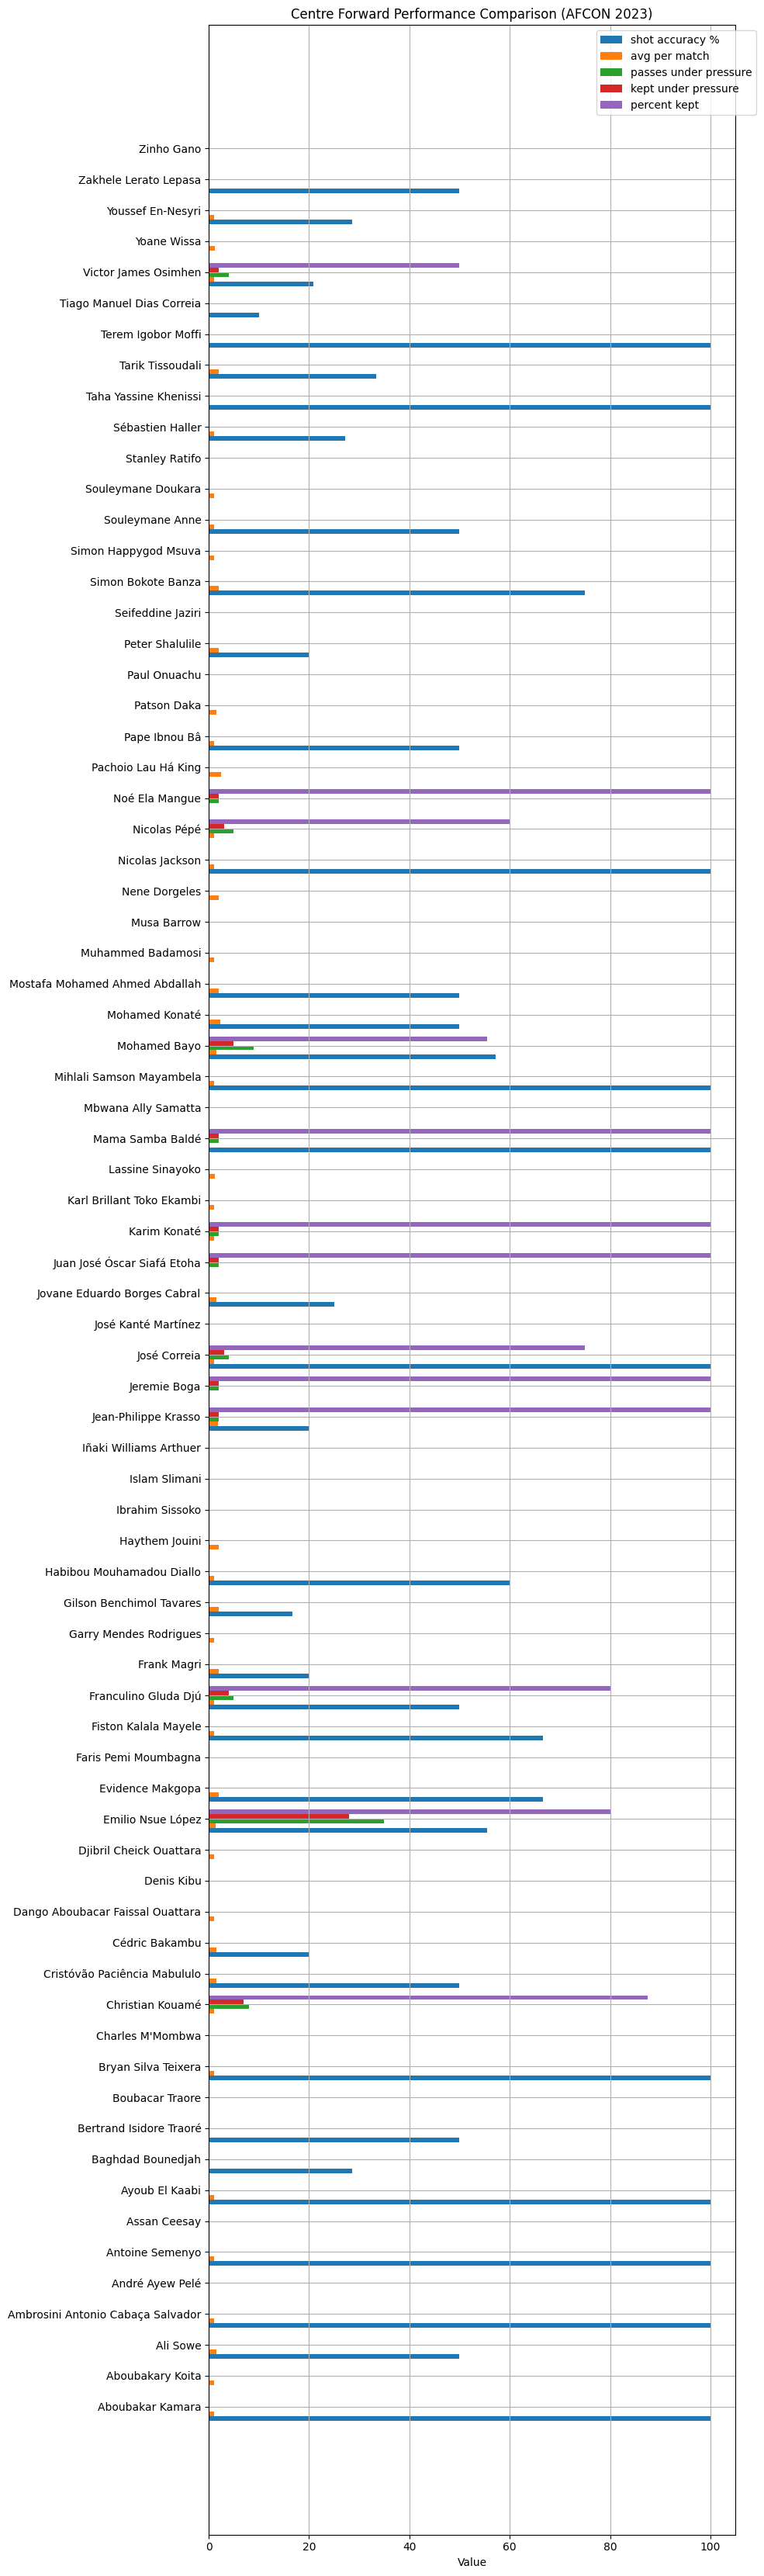

In [33]:
import matplotlib.pyplot as plt
import numpy as np

players = df["player"]
y = np.arange(len(players))

bar_height = 0.15
n = len(metrics)

plt.figure(figsize=(10, max(6, len(players)*0.45)))

for i, m in enumerate(metrics):
    
    plt.barh(
        y + i*bar_height,
        df[m],
        height=bar_height,
        label=m.replace("_"," ")
    )

plt.yticks(y + bar_height*(n/2), players)
plt.xlabel("Value")
plt.title("Centre Forward Performance Comparison (AFCON 2023)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1))

plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
import numpy as np

# copy numeric columns only
num_cols = df.columns.drop(["player","breakdown"])

# Z-score
df_z = df.copy()
df_z[num_cols] = (df[num_cols] - df[num_cols].mean()) / df[num_cols].std()


In [35]:
df_z["overall_score"] = df_z[num_cols].mean(axis=1)


In [36]:
df_z = df_z.sort_values("overall_score", ascending=False)
df_z
df_z.head(74)

,player,total_shots,on_target,shot_accuracy_%,total,num_matches,avg_per_match,breakdown,passes_under_pressure,kept_under_pressure,percent_kept,overall_score
19,Emilio Nsue López,1.491489,2.541776,0.704477,1.053360,1.347793,0.615846,"{3920386: 2, 3920408: 1, 3922239: 1}",7.780566,7.884490,1.981514,2.822368
69,Victor James Osimhen,5.170494,2.541776,-0.243360,1.053360,2.120945,0.171695,"{3920398: 1, 3920409: 1, 3922321: 1, 3922837: 1}",0.663892,0.329829,1.071122,1.431084
20,Evidence Makgopa,1.491489,3.192611,1.007686,2.943025,2.120945,1.517607,"{3922243: 2, 3922658: 1, 3922837: 2, 3923880: 3}",-0.254389,-0.251298,-0.446199,1.257942
32,Jean-Philippe Krasso,0.510421,-0.061566,-0.266012,3.415441,2.894098,1.248424,"{3920384: 4, 3920398: 1, 3920408: 1, 3922242: ...",0.204752,0.329829,2.588443,1.207092
44,Mohamed Bayo,1.000955,1.890940,0.747597,0.580944,0.574640,0.844651,"{3920401: 2, 3922239: 1}",1.811743,1.201521,1.239848,1.099204
14,Cristóvão Paciência Mabululo,2.717824,3.843446,0.552735,0.580944,0.574640,0.844651,"{3920403: 1, 3922237: 2}",-0.254389,-0.251298,-0.446199,0.906928
15,Cédric Bakambu,1.736756,0.589270,-0.266012,2.943025,2.894098,0.979242,"{3920395: 1, 3920405: 2, 3922240: 1, 3922356: ...",-0.254389,-0.251298,-0.446199,0.880499
45,Mohamed Konaté,0.265154,0.589270,0.552735,2.470609,1.347793,1.961758,"{3920392: 3, 3920402: 1, 3922244: 3}",-0.254389,-0.251298,-0.446199,0.692826
13,Christian Kouamé,-0.715914,-0.712401,-0.811843,0.580944,1.347793,0.171695,"{3920398: 1, 3920408: 1, 3922659: 1}",1.582172,1.782649,2.209112,0.603801
46,Mostafa Mohamed Ahmed Abdallah,1.246222,1.890940,0.552735,0.108528,-0.198512,1.517607,{3920411: 2},-0.254389,-0.251298,-0.446199,0.462848


In [37]:
nsue = "Emilio Nsue López"

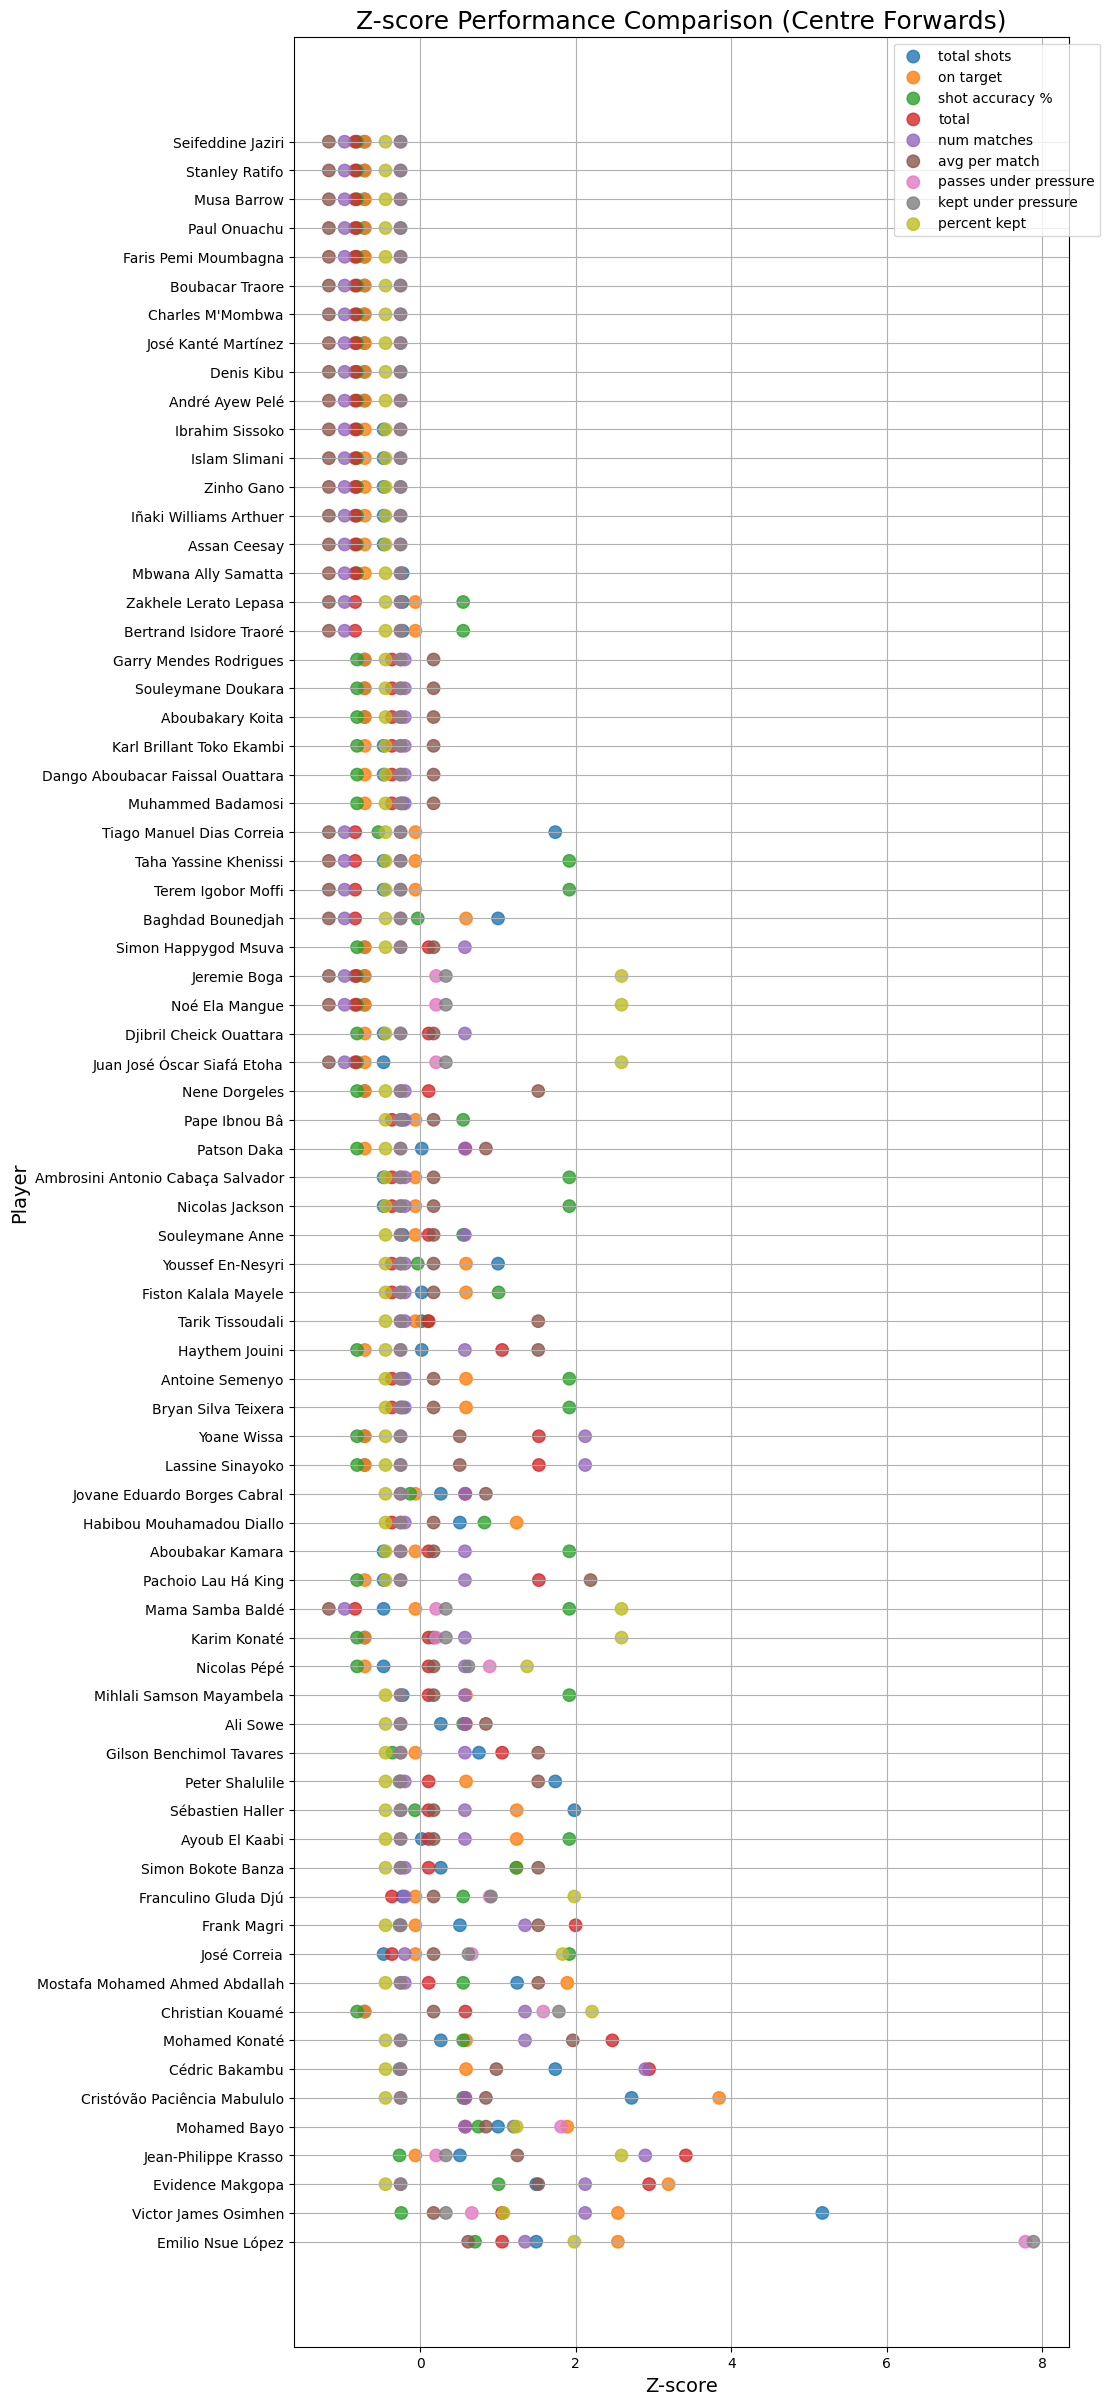

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 30))

# Assign a unique color for each metric
metric_colors = {
    num_cols[i]: plt.cm.tab10(i)   # automatically picks different colors
    for i in range(len(num_cols))
}

for col in num_cols:

    color = metric_colors[col]     # get color for this metric

    plt.scatter(
        df_z[col],                 # Z-score values
        df_z["player"],            # y axis
        label=col.replace("_", " "),
        s=80,
        c=[color] * len(df_z),     # same color for all players of that metric
        alpha=0.8
    )

plt.title("Z-score Performance Comparison (Centre Forwards)", fontsize=18)
plt.xlabel("Z-score", fontsize=14)
plt.ylabel("Player", fontsize=14)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()


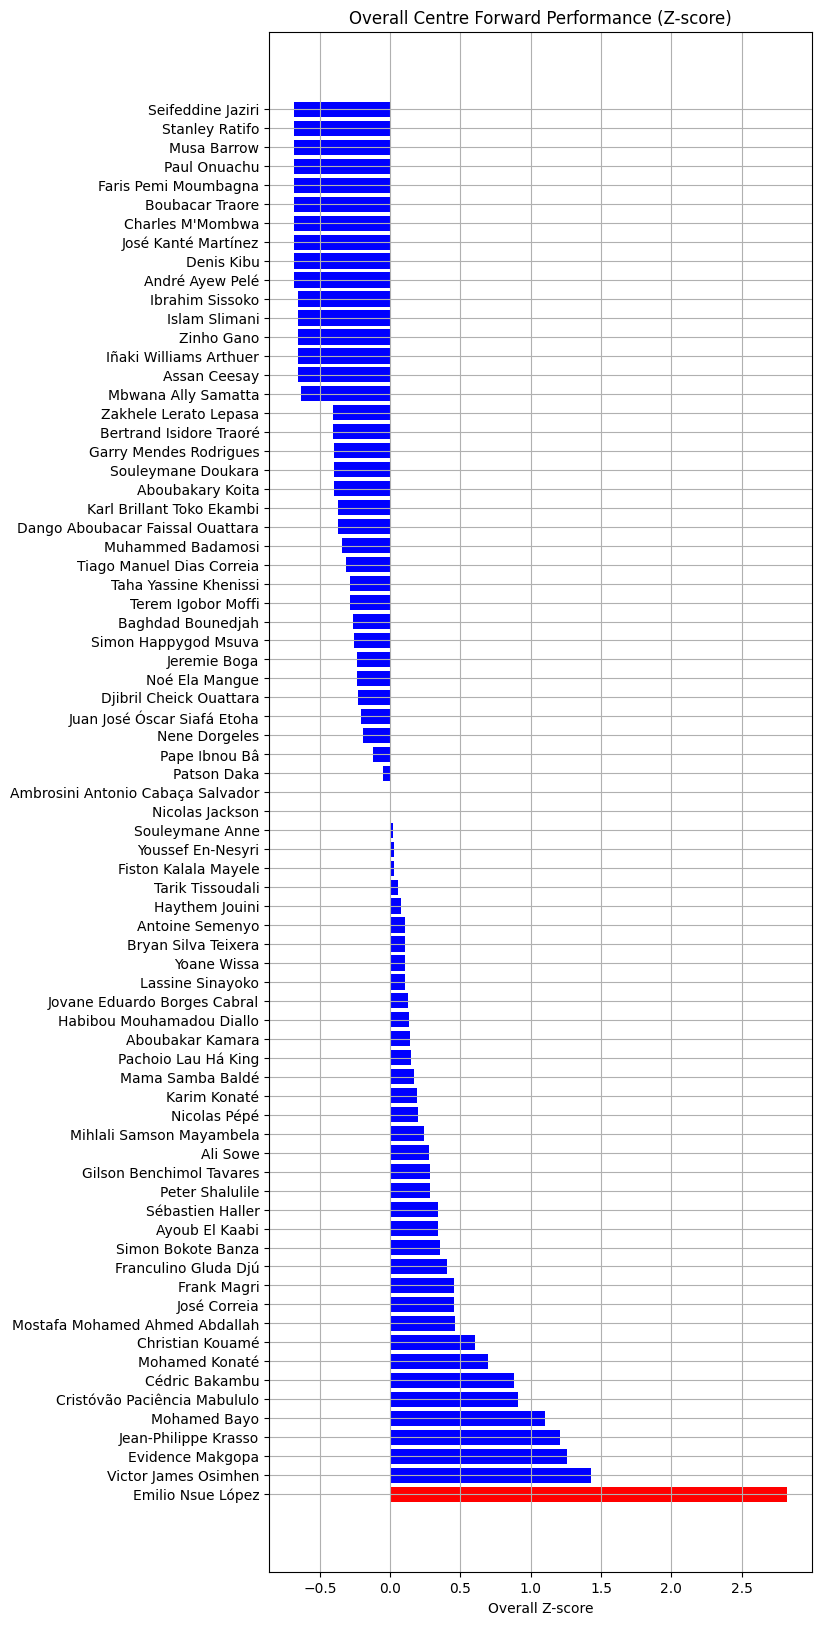

In [39]:
plt.figure(figsize=(7,20))

colors = ["red" if p == nsue else "blue" for p in df_z["player"]]

plt.barh(df_z["player"], df_z["overall_score"], color=colors)

plt.title("Overall Centre Forward Performance (Z-score)")
plt.xlabel("Overall Z-score")
plt.grid(True)

plt.show()


In [40]:
df_z.head(74)

,player,total_shots,on_target,shot_accuracy_%,total,num_matches,avg_per_match,breakdown,passes_under_pressure,kept_under_pressure,percent_kept,overall_score
19,Emilio Nsue López,1.491489,2.541776,0.704477,1.053360,1.347793,0.615846,"{3920386: 2, 3920408: 1, 3922239: 1}",7.780566,7.884490,1.981514,2.822368
69,Victor James Osimhen,5.170494,2.541776,-0.243360,1.053360,2.120945,0.171695,"{3920398: 1, 3920409: 1, 3922321: 1, 3922837: 1}",0.663892,0.329829,1.071122,1.431084
20,Evidence Makgopa,1.491489,3.192611,1.007686,2.943025,2.120945,1.517607,"{3922243: 2, 3922658: 1, 3922837: 2, 3923880: 3}",-0.254389,-0.251298,-0.446199,1.257942
32,Jean-Philippe Krasso,0.510421,-0.061566,-0.266012,3.415441,2.894098,1.248424,"{3920384: 4, 3920398: 1, 3920408: 1, 3922242: ...",0.204752,0.329829,2.588443,1.207092
44,Mohamed Bayo,1.000955,1.890940,0.747597,0.580944,0.574640,0.844651,"{3920401: 2, 3922239: 1}",1.811743,1.201521,1.239848,1.099204
14,Cristóvão Paciência Mabululo,2.717824,3.843446,0.552735,0.580944,0.574640,0.844651,"{3920403: 1, 3922237: 2}",-0.254389,-0.251298,-0.446199,0.906928
15,Cédric Bakambu,1.736756,0.589270,-0.266012,2.943025,2.894098,0.979242,"{3920395: 1, 3920405: 2, 3922240: 1, 3922356: ...",-0.254389,-0.251298,-0.446199,0.880499
45,Mohamed Konaté,0.265154,0.589270,0.552735,2.470609,1.347793,1.961758,"{3920392: 3, 3920402: 1, 3922244: 3}",-0.254389,-0.251298,-0.446199,0.692826
13,Christian Kouamé,-0.715914,-0.712401,-0.811843,0.580944,1.347793,0.171695,"{3920398: 1, 3920408: 1, 3922659: 1}",1.582172,1.782649,2.209112,0.603801
46,Mostafa Mohamed Ahmed Abdallah,1.246222,1.890940,0.552735,0.108528,-0.198512,1.517607,{3920411: 2},-0.254389,-0.251298,-0.446199,0.462848


In [41]:
%pip install streamlit pandas matplotlib seaborn numpy


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
df_z3 = df_z.drop(columns=["breakdown"])
df_z3.to_csv("data/df_z.csv", index=False)

2025-12-07 10:06:45.424 No runtime found, using MemoryCacheStorageManager
2025-12-07 10:06:45.427 No runtime found, using MemoryCacheStorageManager
2025-12-07 10:06:45.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.429 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.431 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-07 10:06:45.437 Thread 'MainThread': missing ScriptRunContext! This warning can be ignor

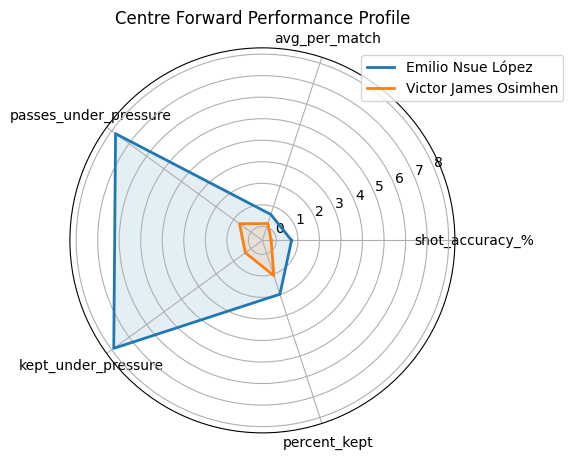

In [50]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Load your data
# ----------------------------------------------------------
@st.cache_data
def load_data():
    df = pd.read_csv("data/df_z.csv")     # your z-score or raw metrics
    return df

df = load_data()

# ----------------------------------------------------------
# Define metrics
# ----------------------------------------------------------
plot_cols = [
    "shot_accuracy_%",
    "avg_per_match",
    "passes_under_pressure",
    "kept_under_pressure",
    "percent_kept"
]

# Make sure all metrics numeric
df[plot_cols] = df[plot_cols].apply(pd.to_numeric, errors='coerce')

# ----------------------------------------------------------
# Radar chart function
# ----------------------------------------------------------
def radar_chart(data, title):
    
    labels = plot_cols
    num = len(labels)

    angles = np.linspace(0, 2*np.pi, num, endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))

    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(polar=True))

    for player, row in data.iterrows():
        vals = row.values
        vals = np.concatenate((vals, [vals[0]]))
        
        ax.plot(angles, vals, linewidth=2, label=player)
        ax.fill(angles, vals, alpha=0.12)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3,1))

    return fig

# ----------------------------------------------------------
# Streamlit UI
# ----------------------------------------------------------
st.title("Centre Forward Performance Dashboard — AFCON 2023")

# ----------------------------------------------------------
# Player selection
# ----------------------------------------------------------
players = df["player"].unique().tolist()
selected = st.multiselect("Select players to compare", players, default=players[:2])

if len(selected) < 1:
    st.warning("Select at least one player.")
    st.stop()

# ----------------------------------------------------------
# Filter data
# ----------------------------------------------------------
comp = df[df["player"].isin(selected)].set_index("player")[plot_cols]

# ----------------------------------------------------------
# Display table
# ----------------------------------------------------------
st.subheader("Metrics Table")
st.dataframe(comp)

# ----------------------------------------------------------
# Radar chart
# ----------------------------------------------------------
st.subheader("Radar Comparison")
fig = radar_chart(comp, "Centre Forward Performance Profile")
st.pyplot(fig)

# ----------------------------------------------------------
# Additional summary
# ----------------------------------------------------------
st.subheader("Summary")
st.write("""
The radar chart compares key attacking and possession metrics:
- Shot accuracy (%) shows finishing efficiency.
- Average goals per match reflects scoring consistency.
- Passes under pressure & passes kept under pressure measure link-up quality.
- Percentage kept shows composure under defensive pressure.
""")
